In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import style
import librosa
import IPython.display
import librosa.display
import os
import random
from matplotlib.pyplot import specgram
import glob

In [2]:
def extract_feature(file_name):
    X, sample_rate = librosa.load(file_name)
    np.nan_to_num(X)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
    return mfccs, chroma, mel, contrast, tonnetz


def parse_audio_files(parent_dir, sub_dirs, classes, file_ext='*.ogg'):
    features, labels = np.empty((0, 193)), np.empty(0)
    for label, sub_dir in enumerate(sub_dirs):
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            mfccs, chroma, mel, contrast,tonnetz = extract_feature(fn)
            ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
            features = np.vstack([features,ext_features])
            labels = np.append(labels, classes.get(sub_dir))
    return np.array(features), np.array(labels, dtype = np.int)


def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels, n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode

In [3]:
data_dir = '../data/esc-50'
sample_dir = os.path.join(data_dir, 'sample')
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

print 'Sound Sample Classes'
print '--------------------'
for d in os.listdir(sample_dir):
    print d

Sound Sample Classes
--------------------
rooster
coughing
insects
laughing


In [4]:
samples_dict = dict()
for d in os.listdir(sample_dir):
    sample_class_dir = os.path.join(sample_dir, d)
    samples_dict[d] = [os.path.join(sample_class_dir, f) for f in os.listdir(sample_class_dir)]

In [5]:
mfccs, chroma, mel, contrast,tonnetz = extract_feature(samples_dict.get('insects')[0])
ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])

In [6]:
mfccs, chroma, mel, contrast,tonnetz = extract_feature(samples_dict.get('insects')[0])
ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
print len(ext_features)

193


In [7]:
features = np.empty((0,193))
print features.shape

(0, 193)


In [8]:
features = np.vstack([features,ext_features])
print features

[[ -2.71008667e+02   1.11177134e+02  -2.66969894e+01   1.64818867e+01
   -4.28178103e-01  -1.32390633e+01   1.21125811e+00  -5.36048044e+00
   -1.12257893e+01  -1.54257043e+01  -1.81542393e+01  -1.80371958e+01
   -1.07932755e+01  -8.53481359e+00  -6.64451044e+00  -1.93843792e+00
   -1.12454952e+01  -1.68509149e+01  -1.28325805e+01  -1.23412747e+01
   -9.02519197e+00  -5.68524379e+00  -5.22570074e+00  -7.41173323e+00
   -1.38022800e+01  -1.52868561e+01  -1.31671584e+01  -9.81586918e+00
   -6.73705615e+00  -8.49936622e+00  -1.17248014e+01  -1.46298240e+01
   -1.01961189e+01   3.74741798e+00   2.14096003e+01   3.56850792e+01
    3.83353708e+01   2.89771481e+01   1.19066973e+01  -2.89713765e+00
    1.59088475e-01   3.19025165e-01   3.33885749e-01   1.52062355e-01
    1.77843989e-01   2.93502119e-01   8.13136173e-01   8.85314120e-01
    3.31957176e-01   1.98507119e-01   3.94651468e-01   3.02763397e-01
    8.68044150e-02   1.83963744e-02   1.35715236e-02   2.39104148e-02
    1.39743146e-01  

In [9]:
sample_dir = os.path.join(data_dir, 'sample')
sub_dirs = ['laughing', 'coughing', 'insects', 'rooster']
classes = {'laughing': 0, 'coughing': 1, 'insects': 2, 'rooster': 3}
features, labels = parse_audio_files(sample_dir, sub_dirs, classes)

In [10]:
print features.shape

(156, 193)


In [11]:
one_hot = one_hot_encode(labels)

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    one_hot, 
                                                    test_size=0.15, 
                                                    random_state=42)
print X_train.shape
print y_train.shape

(132, 193)
(132, 4)


In [56]:
n_hidden_units_one = 50 
n_hidden_units_two = 50

n_classes = 4
n_dim = X_train.shape[1]

In [57]:
from keras.models import Sequential
from keras.layers import Dense
import numpy

In [58]:
model = Sequential()
model.add(Dense(n_hidden_units_one, input_dim=n_dim, kernel_initializer='uniform', activation='relu'))
model.add(Dense(n_hidden_units_two, kernel_initializer='uniform', activation='relu'))
model.add(Dense(n_classes, kernel_initializer='uniform', activation='softmax'))

In [59]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [60]:
model.fit(X_train, y_train, nb_epoch=10, batch_size=20)

Epoch 1/10
132/132 [==============================] - 0s - loss: 1.3210 - acc: 0.3636     
Epoch 2/10
132/132 [==============================] - 0s - loss: 1.1869 - acc: 0.5530     
Epoch 3/10
132/132 [==============================] - 0s - loss: 1.0305 - acc: 0.6136     
Epoch 4/10
132/132 [==============================] - 0s - loss: 0.8609 - acc: 0.6970     
Epoch 5/10
132/132 [==============================] - 0s - loss: 0.7235 - acc: 0.7500     
Epoch 6/10
132/132 [==============================] - 0s - loss: 0.6231 - acc: 0.7879     
Epoch 7/10
132/132 [==============================] - 0s - loss: 0.5371 - acc: 0.8258     
Epoch 8/10
132/132 [==============================] - 0s - loss: 0.4258 - acc: 0.8788     
Epoch 9/10
132/132 [==============================] - 0s - loss: 0.3891 - acc: 0.8712     
Epoch 10/10
132/132 [==============================] - 0s - loss: 0.3196 - acc: 0.9015     


In [61]:
scores = model.evaluate(X_test, y_test)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

24/24 [==============================] - 0s
acc: 83.33%


In [14]:
from sklearn.decomposition import PCA
from sklearn import preprocessing
import pandas as pd

features_df = pd.DataFrame(features)
data_scaled = pd.DataFrame(preprocessing.scale(features_df), columns=features_df.columns)
pca = PCA(n_components=5)
pca_results = pca.fit_transform(data_scaled)

print 'Shape of the transformed feature vector:', pca_results.shape
print 'Original training sample:', list(features_df.loc[0].values)
print 'Training sample after PCA:', list(pca_results[0])
print '\n'
# Percentage of variance explained for each components
print 'Explained variance ratio (first five components)'
print '------------------------------------------------'
for idx, r in enumerate(pca.explained_variance_ratio_):
    print 'Principal Component', idx, ':', r 

 Shape of the transformed feature vector: (156, 5)
Original training sample: [-211.95342873967343, 126.77311337329317, -34.790516564858109, -10.512615152990707, -36.476548766848765, -15.265458386539253, -25.452147024852891, -5.373759791325627, -17.113109621494466, 9.623134344549225, -10.928963826555067, -10.522028894620606, -8.9315416259630567, -4.2521794394544665, -10.441037332644855, -7.5970087415701366, -8.8785380383648729, -1.1939344747472949, -7.0908558885145743, 0.76262883957394723, -6.841079475167918, -6.7085224890121546, -4.9157763803929528, -2.7260106406212623, -6.4026770846192411, -2.3801003698167018, -6.0828079226609626, -1.005822607342773, -4.4659888523414537, -1.1620847727575108, -4.0551530678673311, -0.10143759270967795, -5.5333870628773516, -1.0524975933573175, -3.2479466396041592, -1.5511760810055846, -3.3662660397266997, -2.0985671973177058, -3.8624834878166756, -0.23053952005125813, 0.51834445566621268, 0.50731462792430559, 0.54732341782571448, 0.54456663467689226, 0.

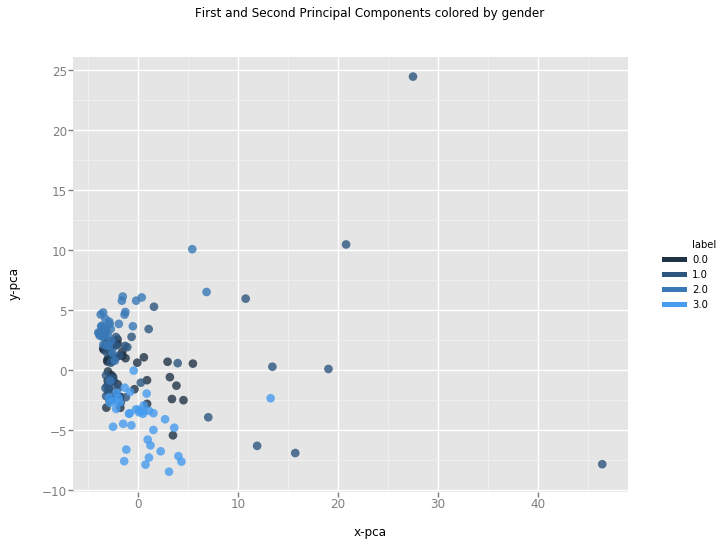

<ggplot: (8730928897673)>

In [18]:
from ggplot import *

df_pca = features_df.copy()
df_pca['x-pca'] = pca_results[:,0]
df_pca['y-pca'] = pca_results[:,1]
df_pca['label'] = labels
chart = ggplot( df_pca, aes(x='x-pca', y='y-pca', color='label') ) \
        + geom_point(size=75,alpha=0.8) \
        + ggtitle("First and Second Principal Components colored by gender")
chart

In [22]:
from sklearn.manifold import TSNE

print("Computing t-SNE embedding")
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=500)
tsne_results = tsne.fit_transform(features_df)

Computing t-SNE embedding
[t-SNE] Computing pairwise distances...
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 156 / 156
[t-SNE] Mean sigma: 46.734307
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.395291
[t-SNE] Error after 400 iterations: 1.395291


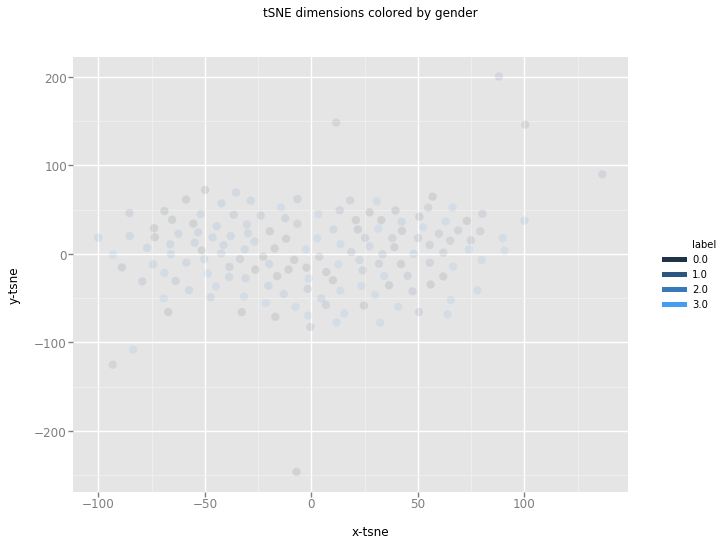

<ggplot: (8730928702225)>

In [23]:
df_tsne = features_df.copy()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]
df_tsne['label'] = labels
chart = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne', color='label') ) \
        + geom_point(size=70,alpha=0.1) \
        + ggtitle("tSNE dimensions colored by gender")
chart

In [28]:
from sklearn.manifold import TSNE

print("Computing t-SNE embedding")
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000)
tsne_results = tsne.fit_transform(pca_results)

Computing t-SNE embedding
[t-SNE] Computing pairwise distances...
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 156 / 156
[t-SNE] Mean sigma: 3.671794
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.414827
[t-SNE] Error after 325 iterations: 1.414827


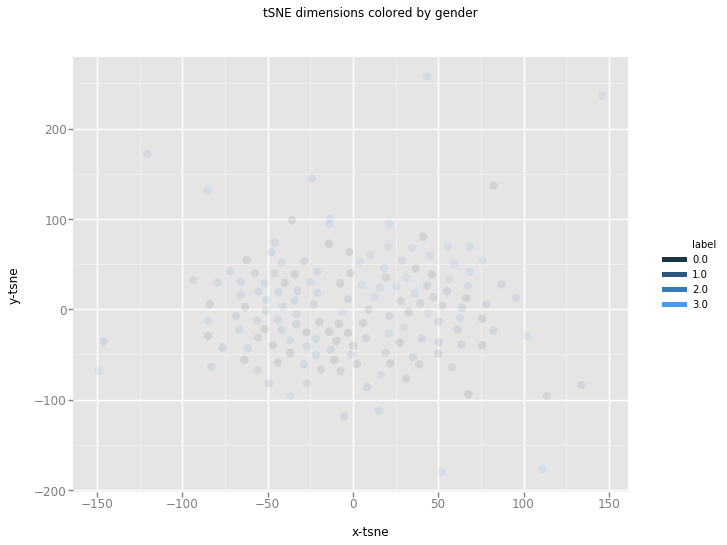

<ggplot: (8730928573909)>

In [29]:
df_tsne = features_df.copy()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]
df_tsne['label'] = labels
chart = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne', color='label') ) \
        + geom_point(size=70,alpha=0.1) \
        + ggtitle("tSNE dimensions colored by gender")
chart